# Developing a Personalized Movie Recommendation System 
## CS5100 Final Project

#### By: Abdelrahman Zeidan

### Project Overview
The goal of this project is to develop a comprehensive **movie recommendation system** using various techniques to enhance the accuracy of recommendations. The project explores multiple approaches, including:

1. **User-User Collaborative Filtering**: Recommends movies by finding users with similar preferences and suggesting items they have rated highly.
2. **Item-Item Collaborative Filtering**: Recommends movies by finding items (movies) similar to those a user has already rated highly and suggesting the most similar items the user has not yet rated.
3. **Content-Based Filtering**: Uses the movie genres to recommend similar movies based on a user's past preferences.

### Dataset
In the initial project proposal, the **MovieLens 32M dataset** was selected due to its extensive coverage, with millions of ratings from a large user base. However, for simplicity and to limit computational resource requirements during the initial development phase, this project uses the **MovieLens 100k dataset**.

The **MovieLens 100k dataset** contains:
- 100,000 ratings from 1,000 users on 1,700 movies.
- Rich metadata such as movie titles, genres, and release dates.

**Source**: [MovieLens Dataset](https://grouplens.org/datasets/movielens/)

### Objectives
The main objectives of this project are:
- To explore and compare different recommendation techniques.
- To develop a functional recommendation system that can predict movies a user is likely to enjoy.
- To evaluate the effectiveness of these models using standard metrics like **RMSE** and **MAE**, and assess model performance via **Residual Analysis**.

### Structure of the Notebook
This notebook is organized into the following sections:
1. **Data Loading and Exploration**: Loads and explores the dataset to understand its structure.
2. **User-User Collaborative Filtering**: Implements a collaborative filtering model based on user similarity.
3. **Item-Item Collaborative Filtering**: Implements a collaborative filtering model based on item similarity to recommend movies.
4. **Content-Based Filtering**: Implements a content-based model using genres to recommend similar movies.
5. **Performance Evaluation**: Compares the performance of all models based on **RMSE**, **MAE**, and **Residual Analysis** to identify the most effective approach.
6. **Conclusions**: Discusses results, insights, and potential improvements.


# Data Loading and Exploration

In [74]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [75]:
# Load the data into DataFrames and display the tables
movies_df = pd.read_csv("ml-latest-small/movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [76]:
print("Movies Dataset Information:")
movies_df.info()

Movies Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [77]:
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [78]:
print("Ratings Dataset Information:")
print(ratings_df.info())

Ratings Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [79]:
tags_df = pd.read_csv("ml-latest-small/tags.csv")
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [80]:
# Merge the movies and ratings data on 'movieId'
merged_df = pd.merge(ratings_df, movies_df, on='movieId')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [81]:
print(merged_df.shape)

(100836, 6)


In [82]:
# Check for missing values
print(merged_df.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


In [83]:
# Drop duplicates
merged_df.drop_duplicates(inplace=True)

In [84]:
# show Data Summary
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [85]:
print(f"Number of unique users: {merged_df['userId'].nunique()}")
print(f"Number of unique movies: {merged_df['movieId'].nunique()}")

Number of unique users: 610
Number of unique movies: 9724


In [86]:
# Basic statistics
print("Statistics of Ratings:")
merged_df['rating'].describe()

Statistics of Ratings:


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

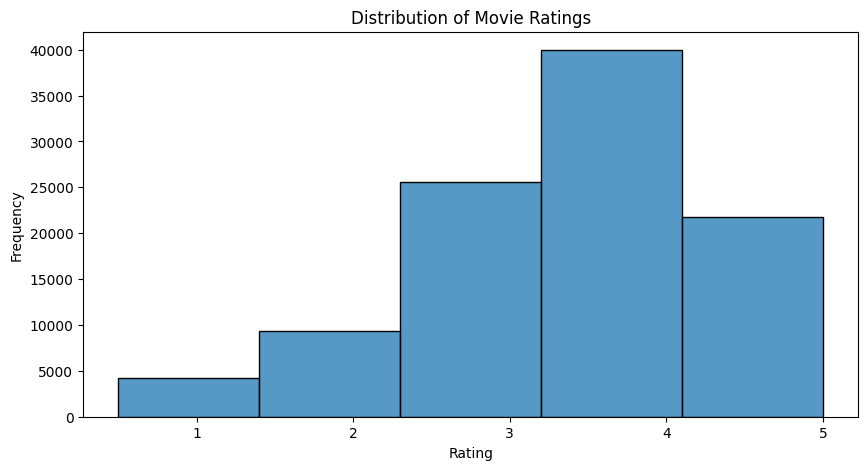

In [87]:
# Display Distribution of Ratings
plt.figure(figsize=(10,5))
sns.histplot(merged_df['rating'], bins=5)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

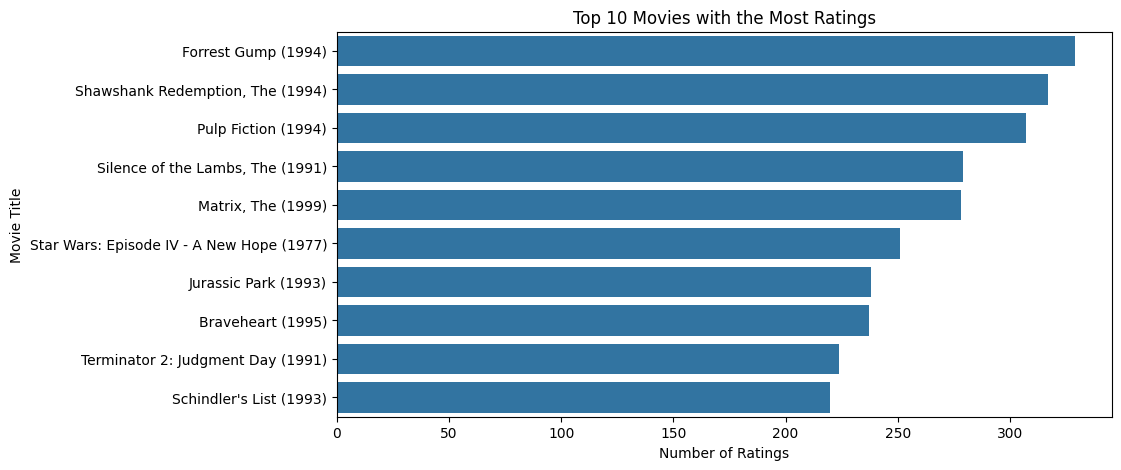

In [88]:
# Display Count of Ratings per Movie
top_movies = merged_df['title'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_movies.values, y=top_movies.index)
plt.title('Top 10 Movies with the Most Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

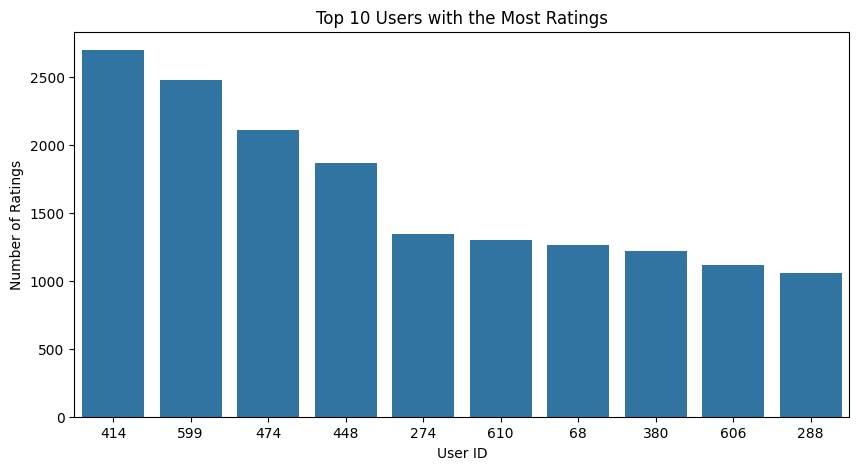

In [89]:
# Display Count of Ratings per User
top_users = merged_df['userId'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_users.index.astype(str) , y=top_users.values)
plt.title('Top 10 Users with the Most Ratings')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.show()


# User-User Collaborative Filtering

I will start by implementing a User-User Collaborative Filtering model. This model recommends movies to a user by finding other users with similar preferences and suggesting movies that those similar users have liked.

### Steps:
1. ***Create a User-Item Matrix:*** Transform the data into a matrix (pivot table) where rows represent users and columns represent movies, with each cell containing the user's rating for that movie.
2. ***Compute Similarity between Users:*** Use cosine similarity to measure how similar each user is to others based on their ratings.
3. ***Generate Recommendations:*** For a given user, find the top similar users and recommend movies they have rated highly.
4. ***Evaluate the Model:*** 
   - Split the data into training and test sets.
   - Predict ratings for user-item pairs in the test set.
   - Calculate performance metrics such as RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) to evaluate how accurately the model predicts user preferences.


In [90]:
# Create a User-Item Matrix
user_movie_matrix = merged_df.pivot_table(index='userId', columns='title', values='rating').fillna(0)
user_movie_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


In [91]:
# Compute Cosine Similarity between Users
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)
user_similarity_df


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
607,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
608,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055


In [ ]:
# Create a function to Recommend Movies Based on User Similarity
def recommend_movies(user_id, user_movie_matrix, user_similarity_df, num_recommendations=5):
    """
    Recommend movies for a given user based on similar users' ratings.
    """
    # find the most similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:6]

    # get the average ratings of the top similar users
    similar_user_ratings = user_movie_matrix.loc[similar_users].mean()

    # get movies that the target user has not rated yet
    user_ratings = user_movie_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings == 0].index

    # recommend the top unrated movies
    recommendations = similar_user_ratings[unrated_movies].sort_values(ascending=False).head(num_recommendations)

    return recommendations



In [93]:
# Example: get Recommendations for a Specific User (User 1)
user_id = 1
recommended_movies = recommend_movies(user_id, user_movie_matrix, user_similarity_df)
print(f"\nRecommended Movies for User {user_id}:")
display(recommended_movies)

# Example: get Recommendations for a Specific User (User 2)
user_id = 2
recommended_movies = recommend_movies(user_id, user_movie_matrix, user_similarity_df)
print(f"\nRecommended Movies for User {user_id}:")
display(recommended_movies)

# Example: get Recommendations for a Specific User (User 50)
user_id = 50
recommended_movies = recommend_movies(user_id, user_movie_matrix, user_similarity_df)
print(f"\nRecommended Movies for User {user_id}:")
display(recommended_movies)


Recommended Movies for User 1:


title
Aliens (1986)                        4.8
Hunt for Red October, The (1990)     4.3
Die Hard (1988)                      4.0
Godfather, The (1972)                4.0
Terminator 2: Judgment Day (1991)    4.0
dtype: float64


Recommended Movies for User 2:


title
Lord of the Rings: The Fellowship of the Ring, The (2001)    3.6
Lord of the Rings: The Return of the King, The (2003)        3.6
Fight Club (1999)                                            3.4
Matrix, The (1999)                                           2.7
Lord of the Rings: The Two Towers, The (2002)                2.7
dtype: float64


Recommended Movies for User 50:


title
One Flew Over the Cuckoo's Nest (1975)                   4.3
Departed, The (2006)                                     4.2
Seven (a.k.a. Se7en) (1995)                              4.1
Reservoir Dogs (1992)                                    4.0
Star Wars: Episode V - The Empire Strikes Back (1980)    3.8
dtype: float64

#### Evaluate the model

In [ ]:
# Step 1: Split the data
# Keep only relevant columns for collaborative filtering
ratings_data = merged_df[['userId', 'title', 'rating']]

# Split into train and test sets
train_data_user_user, test_data_user_user = train_test_split(ratings_data, test_size=0.2, random_state=42)

# Step 2: Create User-Item Matrix for the training set
user_movie_matrix_train = train_data_user_user.pivot_table(index='userId', columns='title', values='rating').fillna(0)

# Create User-Item Matrix for the test set
user_movie_matrix_test = test_data_user_user.pivot_table(index='userId', columns='title', values='rating').fillna(0)

# Compute user-user similarity matrix using the training data
user_similarity_train = cosine_similarity(user_movie_matrix_train)
user_similarity_train_df = pd.DataFrame(user_similarity_train, index=user_movie_matrix_train.index, columns=user_movie_matrix_train.index)

# Step 3: Function to predict ratings for a specific user
def predict_rating(user_id, item, user_movie_matrix_train, user_similarity_train_df):
    """
    Predict a rating for a specific user-item pair using User-User Collaborative Filtering.
    """
    # Get similar users
    similar_users = user_similarity_train_df[user_id]

    # Get ratings for the specific item from similar users
    item_ratings = user_movie_matrix_train[item]

    # Compute the weighted average of ratings
    weighted_sum = (similar_users * item_ratings).sum()
    sim_sum = similar_users[item_ratings > 0].sum()

    if sim_sum == 0:
        return 0
    return weighted_sum / sim_sum

# Step 4: Evaluate on the test set
def evaluate_model(test_data, user_movie_matrix_train, user_similarity_train_df):
    """
    Evaluate the User-User Collaborative Filtering model using RMSE and MAE.
    """
    y_true = []
    y_pred = []

    for _, row in test_data.iterrows():
        user_id = row['userId']
        title = row['title']
        actual_rating = row['rating']

        # Predict the rating
        if title in user_movie_matrix_train.columns:
            predicted_rating = predict_rating(user_id, title, user_movie_matrix_train, user_similarity_train_df)
        else:
            predicted_rating = user_movie_matrix_train.loc[user_id].mean()

        y_true.append(actual_rating)
        y_pred.append(predicted_rating)

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return y_true, y_pred, rmse, mae

# Step 5: Run the evaluation
y_true_user_user, y_pred_user_user, rmse_user_user, mae_user_user = evaluate_model(
    test_data_user_user, user_movie_matrix_train, user_similarity_train_df
)

print(f"RMSE (User-User CF): {rmse_user_user:.4f}")
print(f"MAE (User-User CF): {mae_user_user:.4f}")

RMSE (User-User CF): 1.1438
MAE (User-User CF): 0.8385


# Item-Item Collaborative Filtering

I will now implement an Item-Item Collaborative Filtering model. This model recommends movies to a user by finding items (movies) similar to those they have already interacted with and suggesting the most similar items that the user has not rated yet.

### Steps:
1. ***Create a User-Item Matrix:*** Transform the data into a matrix (pivot table) where rows represent users and columns represent items (movies), with each cell containing the user's rating for that item.
2. ***Compute Similarity between Items:*** Use cosine similarity to measure how similar each item is to other items based on user ratings.
3. ***Generate Recommendations:*** For a given user, find the items they have rated and identify items that are most similar to those rated items. Recommend the top similar items that the user has not rated yet.
4. ***Evaluate the Model:*** 
   - Split the data into training and test sets.
   - Predict ratings for user-item pairs in the test set.
   - Calculate performance metrics such as RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) to evaluate how accurately the model predicts user preferences.


In [95]:
# Create a User-Movie Matrix
user_movie_matrix = merged_df.pivot_table(index='userId', columns='title', values='rating').fillna(0)
display(user_movie_matrix)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


In [96]:
# Compute Cosine Similarity Between Movies
movie_similarity = cosine_similarity(user_movie_matrix.T)  # Transpose to compute similarity between movies
movie_similarity_df = pd.DataFrame(movie_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)
display(movie_similarity_df)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.141653,0.000000,...,0.000000,0.342055,0.543305,0.707107,0.0,0.000000,0.139431,0.327327,0.000000,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,1.000000,0.707107,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Round Midnight (1986),0.000000,0.707107,1.000000,0.000000,0.000000,0.0,0.176777,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Salem's Lot (2004),0.000000,0.000000,0.000000,1.000000,0.857493,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Til There Was You (1997),0.000000,0.000000,0.000000,0.857493,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.211467,0.216295,0.097935,0.132489,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.192259,0.000000,0.170341,0.0
xXx (2002),0.139431,0.000000,0.000000,0.000000,0.000000,0.0,0.089634,0.000000,0.276512,0.019862,...,0.069716,0.305535,0.173151,0.246482,0.0,0.192259,1.000000,0.270034,0.100396,0.0
xXx: State of the Union (2005),0.327327,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.156764,0.000000,...,0.000000,0.382543,0.177838,0.231455,0.0,0.000000,0.270034,1.000000,0.000000,0.0


In [97]:
# Create a Function to Recommend Movies Based on Movie Similarity
def recommend_movies_movie_based(user_id, user_movie_matrix, movie_similarity_df, num_recommendations=5):
    """
    Recommend movies for a given user based on movie similarity.
    """
    # Get the user's ratings
    user_ratings = user_movie_matrix.loc[user_id]

    # Get movies the user has rated
    rated_movies = user_ratings[user_ratings > 0].index

    # Create a dictionary to store scores for all unrated movies
    movie_scores = {}

    # For each rated movie, find similar movies and accumulate scores
    for rated_movie in rated_movies:
        similar_movies = movie_similarity_df[rated_movie].sort_values(ascending=False)

        for movie, similarity in similar_movies.items():
            if movie not in rated_movies:
                if movie not in movie_scores:
                    movie_scores[movie] = 0
                movie_scores[movie] += similarity * user_ratings[rated_movie]

    # Sort movies by their scores and return the top recommendations
    recommended_movies = pd.Series(movie_scores).sort_values(ascending=False).head(num_recommendations)
    return recommended_movies

In [98]:
# Example: Get Recommendations for a Specific User (User 1)
user_id = 1
recommended_movies = recommend_movies_movie_based(user_id, user_movie_matrix, movie_similarity_df)
print(f"\nRecommended Movies for User {user_id}:")
display(recommended_movies)

# Example: Get Recommendations for a Specific User (User 2)
user_id = 2
recommended_movies = recommend_movies_movie_based(user_id, user_movie_matrix, movie_similarity_df)
print(f"\nRecommended Movies for User {user_id}:")
display(recommended_movies)

# Example: Get Recommendations for a Specific User (User 50)
user_id = 50
recommended_movies = recommend_movies_movie_based(user_id, user_movie_matrix, movie_similarity_df)
print(f"\nRecommended Movies for User {user_id}:")
display(recommended_movies)


Recommended Movies for User 1:


Ferris Bueller's Day Off (1986)    352.684010
Die Hard (1988)                    330.949884
Breakfast Club, The (1985)         328.180507
Fifth Element, The (1997)          326.437374
Aliens (1986)                      323.117648
dtype: float64


Recommended Movies for User 2:


Hangover, The (2009)          43.201513
Fight Club (1999)             41.689555
Batman Begins (2005)          40.674911
Social Network, The (2010)    40.510569
Avatar (2009)                 39.921421
dtype: float64


Recommended Movies for User 50:


Groundhog Day (1993)                                     192.680997
Reservoir Dogs (1992)                                    192.603963
Star Wars: Episode V - The Empire Strikes Back (1980)    191.747537
Sin City (2005)                                          189.796625
Back to the Future (1985)                                186.713490
dtype: float64

#### Evaluate the model

In [99]:
# Step 1: Split the data
# Keep only relevant columns for collaborative filtering
ratings_data = merged_df[['userId', 'title', 'rating']]

# Split into train and test sets
train_data_item_item, test_data_item_item = train_test_split(ratings_data, test_size=0.2, random_state=42)

# Step 2: Create User-Item Matrix for the training set
user_movie_matrix_train = train_data_item_item.pivot_table(index='userId', columns='title', values='rating').fillna(0)

# Compute item-item similarity matrix using the training data
item_similarity_train = cosine_similarity(user_movie_matrix_train.T)
item_similarity_train_df = pd.DataFrame(item_similarity_train,
                                        index=user_movie_matrix_train.columns,
                                        columns=user_movie_matrix_train.columns)

# Step 3: Function to predict ratings for a specific user and item
def predict_rating_item_based(user_id, item, user_movie_matrix_train, item_similarity_train_df):
    """
    Predict a rating for a specific user-item pair using Item-Item Collaborative Filtering.
    """
    # Get the user's ratings
    user_ratings = user_movie_matrix_train.loc[user_id]

    # Get similarities for the given item
    item_similarities = item_similarity_train_df[item]

    # Compute the weighted sum of ratings
    weighted_sum = (user_ratings * item_similarities).sum()
    rated_items_mask = user_ratings > 0
    sim_sum = item_similarities[rated_items_mask].sum()


    if sim_sum == 0:
        return 0
    return weighted_sum / sim_sum

# Step 4: Evaluate on the test set
def evaluate_item_based_model(test_data, user_movie_matrix_train, item_similarity_train_df):
    """
    Evaluate the Item-Item Collaborative Filtering model using RMSE and MAE.
    """
    y_true = []
    y_pred = []

    for _, row in test_data.iterrows():
        user_id = row['userId']
        title = row['title']
        actual_rating = row['rating']

        # Predict the rating
        if title in user_movie_matrix_train.columns:
            predicted_rating = predict_rating_item_based(user_id, title, user_movie_matrix_train, item_similarity_train_df)
        else:
            predicted_rating = user_movie_matrix_train.loc[user_id].mean()

        y_true.append(actual_rating)
        y_pred.append(predicted_rating)

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return y_true, y_pred, rmse, mae

# Step 5: Run the evaluation
y_true_item_item, y_pred_item_item, rmse_item_item, mae_item_item = evaluate_item_based_model(
    test_data_item_item, user_movie_matrix_train, item_similarity_train_df
)

print(f"RMSE (Item-Item CF): {rmse_item_item:.4f}")
print(f"MAE (Item-Item CF): {mae_item_item:.4f}")

RMSE (Item-Item CF): 1.1044
MAE (Item-Item CF): 0.8011


# Content-Based Filtering Model

I will use Content-Based Filtering, which recommends movies based on their features (like genres) and what the user has liked before. This approach is especially useful because it does not rely on user ratings but instead looks at the content of the items.

### Steps:
1. ***Preprocess the Movie Genres:*** Use TF-IDF Vectorizer to convert the genres into numerical feature vectors.
2. ***Calculate Cosine Similarity between Movies:***  measure how similar two movies are based on their genre vectors.
3. ***Create a Function to Generate Recommendations:*** For a given movie, recommend other movies that are similar based on their genres.
4. ***Evaluate the Model:*** 
    - Split the data into training and test sets.
    - Predict ratings for user-item pairs in the test set.
    - Evaluate the model's performance using metrics like **RMSE** (Root Mean Squared Error) and **MAE** (Mean Absolute Error).


In [100]:
# Preprocess the genres data by filling any missing values with an empty string
movies_df['genres'] = movies_df['genres'].fillna('')
movies_df['genres'].head(10)

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
5                          Action|Crime|Thriller
6                                 Comedy|Romance
7                             Adventure|Children
8                                         Action
9                      Action|Adventure|Thriller
Name: genres, dtype: object

In [101]:
# Use TF-IDF Vectorizer to convert genres into numerical feature vectors
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'), token_pattern=None)
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

# print the feature names
print("TF-IDF Feature Names (genres):")
print(tfidf.get_feature_names_out())

# Convert the TF-IDF matrix to a DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies_df['title'], columns=tfidf.get_feature_names_out())

print("\nTF-IDF Matrix:")
tfidf_df.head()


TF-IDF Feature Names (genres):
['(no genres listed)' 'action' 'adventure' 'animation' 'children' 'comedy'
 'crime' 'documentary' 'drama' 'fantasy' 'film-noir' 'horror' 'imax'
 'musical' 'mystery' 'romance' 'sci-fi' 'thriller' 'war' 'western']

TF-IDF Matrix:


,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
title,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.0,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,0.482990,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Jumanji (1995),0.0,0.0,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,0.593662,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.0,0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.0,0.0,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,0.000000,0.0,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [102]:
# Compute the cosine similarity between all movies based on their genre vectors
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# visualize the cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df

,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
0,1.000000,0.813578,0.152769,0.135135,0.267586,0.000000,0.152769,0.654698,0.000000,0.262413,...,0.411168,0.465621,0.196578,0.516225,0.0,0.680258,0.755891,0.000000,0.421037,0.267586
1,0.813578,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.804715,0.000000,0.322542,...,0.000000,0.000000,0.000000,0.000000,0.0,0.341376,0.379331,0.000000,0.000000,0.000000
2,0.152769,0.000000,1.000000,0.884571,0.570915,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.185790,0.000000,0.419413,0.000000,0.0,0.181883,0.202105,0.000000,0.000000,0.570915
3,0.135135,0.000000,0.884571,1.000000,0.505015,0.000000,0.884571,0.000000,0.000000,0.000000,...,0.164344,0.201391,0.687440,0.000000,0.0,0.160888,0.178776,0.466405,0.000000,0.505015
4,0.267586,0.000000,0.570915,0.505015,1.000000,0.000000,0.570915,0.000000,0.000000,0.000000,...,0.325424,0.000000,0.734632,0.000000,0.0,0.318581,0.354002,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0.680258,0.341376,0.181883,0.160888,0.318581,0.239513,0.181883,0.000000,0.436010,0.241142,...,0.683714,0.554355,0.234040,0.614603,0.0,1.000000,0.899942,0.000000,0.753553,0.318581
9738,0.755891,0.379331,0.202105,0.178776,0.354002,0.000000,0.202105,0.000000,0.000000,0.000000,...,0.543952,0.615990,0.260061,0.682937,0.0,0.899942,1.000000,0.000000,0.557008,0.354002
9739,0.000000,0.000000,0.000000,0.466405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.431794,0.678466,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
9740,0.421037,0.000000,0.000000,0.000000,0.000000,0.317844,0.000000,0.000000,0.578606,0.320007,...,0.769740,0.735655,0.000000,0.815607,0.0,0.753553,0.557008,0.000000,1.000000,0.000000


In [103]:
def get_content_recommendations(title, movies_df, cosine_sim, num_recommendations=5):
    """
    Recommend movies similar to the given title based on genres.
    """
    # Check if the movie title exists in the dataset
    if title not in movies_df['title'].values:
        print(f"Movie '{title}' not found in the dataset.")
        return []

    # Find the index of the movie with the given title
    idx = movies_df.index[movies_df['title'] == title][0]

    # get the similarity scores of all movies with respect to the given movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on their similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Exclude the first entry (itself) and get the indices of the most similar movies
    sim_scores = sim_scores[1:num_recommendations + 1]
    movie_indices = [i[0] for i in sim_scores]

    # Return the titles of the recommended movies
    return movies_df['title'].iloc[movie_indices]


In [104]:
# Test the function

# select random movies from the dataset
random_movies = ["Toy Story (1995)"]
random_movies += movies_df['title'].sample(3).tolist()

# loop through the selected movies and get recommendations for each
for movie in random_movies:
    print(f"\nRecommendations for '{movie}':")
    recommendations = get_content_recommendations(movie, movies_df, cosine_sim, num_recommendations=5)
    recommendations_list = recommendations.tolist()

    if recommendations_list:
        for i, rec in enumerate(recommendations_list, 1):
            print(f"{i}. {rec}")
    else:
        print("No recommendations found.")



Recommendations for 'Toy Story (1995)':
1. Antz (1998)
2. Toy Story 2 (1999)
3. Adventures of Rocky and Bullwinkle, The (2000)
4. Emperor's New Groove, The (2000)
5. Monsters, Inc. (2001)

Recommendations for 'Dogman (2018)':
1. Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
2. Dead Man Walking (1995)
3. Hate (Haine, La) (1995)
4. Young Poisoner's Handbook, The (1995)
5. Heavenly Creatures (1994)

Recommendations for 'Wyrmwood (2015)':
1. Alien: Resurrection (1997)
2. Deep Rising (1998)
3. Alligator (1980)
4. Chopping Mall (a.k.a. Killbots) (1986)
5. Hidden, The (1987)

Recommendations for 'Toni Erdmann (2016)':
1. Othello (1995)
2. Dangerous Minds (1995)
3. Cry, the Beloved Country (1995)
4. Restoration (1995)
5. Georgia (1995)


In [ ]:
# Step 1: Split the data
# Keep only relevant columns for content-based filtering
ratings_data = merged_df[['userId', 'title', 'rating']]

# Split into train and test sets
train_data_content_based, test_data_content_based = train_test_split(ratings_data, test_size=0.2, random_state=42)

# Step 2: Create User-Item Matrix for the training set
user_movie_matrix_train = train_data_content_based.pivot_table(index='userId', columns='title', values='rating').fillna(0)

# Step 3: Compute the cosine similarity between movies based on their genre vectors
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'), token_pattern=None)
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 4: Function to predict ratings for a specific user
def predict_rating_content_based(user_id, item, user_movie_matrix_train, cosine_sim, movies_df, k=50):
    """
    Predict a rating for a specific user-item pair using Content-Based Filtering with optimizations.
    """
    # Get the user's rated movies in the training set
    if user_id not in user_movie_matrix_train.index or item not in movies_df['title'].values:
        return 0

    rated_movies = user_movie_matrix_train.loc[user_id][user_movie_matrix_train.loc[user_id] > 0].index

    # If the item is in the user's rated movies, return the actual rating
    if item in rated_movies:
        return user_movie_matrix_train.loc[user_id, item]

    # Compute cosine similarity only for the target movie
    item_idx = movies_df[movies_df['title'] == item].index[0]
    similarity_scores = cosine_sim[item_idx]

    # Get the top-k most similar movies
    top_k_similar_movies = np.argsort(similarity_scores)[::-1][1:k+1]

    # Predict based on weighted average of similar movies' ratings
    weighted_sum = 0
    sim_sum = 0
    for similar_idx in top_k_similar_movies:
        similar_movie = movies_df.iloc[similar_idx]['title']
        if similar_movie in rated_movies:
            similarity = similarity_scores[similar_idx]
            rating = user_movie_matrix_train.loc[user_id, similar_movie]
            weighted_sum += similarity * rating
            sim_sum += similarity

    return weighted_sum / sim_sum if sim_sum > 0 else 0


# Step 5: Evaluate on the test set
def evaluate_model_content_based(test_data, user_movie_matrix_train, cosine_sim, movies_df):
    """
    Evaluate the Content-Based Filtering model using RMSE and MAE.
    """
    y_true = []
    y_pred = []

    for _, row in test_data.iterrows():
        user_id = row['userId']
        title = row['title']
        actual_rating = row['rating']

        # Predict the rating
        if title in user_movie_matrix_train.columns:
            predicted_rating = predict_rating_content_based(user_id, title, user_movie_matrix_train, cosine_sim, movies_df)
        else:
            predicted_rating = user_movie_matrix_train.loc[user_id].mean()

        y_true.append(actual_rating)
        y_pred.append(predicted_rating)

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return y_true, y_pred, rmse, mae

# Step 6: Run the evaluation
y_true_content_based, y_pred_content_based, rmse_content, mae_content = evaluate_model_content_based(
    test_data_content_based, user_movie_matrix_train, cosine_sim, movies_df
)

print(f"RMSE (Content-Based): {rmse_content:.4f}")
print(f"MAE (Content-Based): {mae_content:.4f}")


RMSE (Content-Based): 2.1264
MAE (Content-Based): 1.5309


# Performance Evaluation

This section compares the models using **RMSE** and **MAE**. These metrics help evaluate how well the models predict ratings:

- **RMSE** (Root Mean Squared Error): Measures the average squared error (lower is better).
- **MAE** (Mean Absolute Error): Measures the average absolute error (lower is better).

Below are the visualizations of RMSE and MAE for each model, followed by a summarized table of the results.


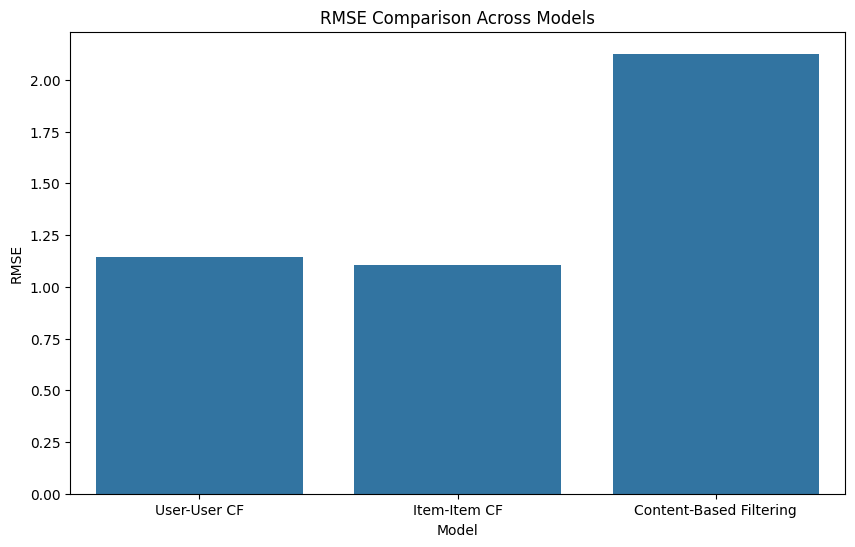

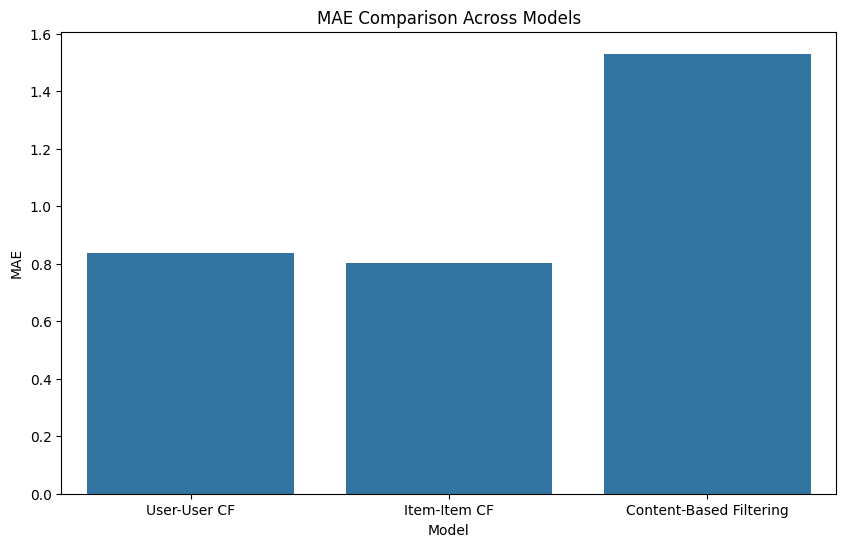

Performance Comparison:


,Model,RMSE,MAE
0,User-User CF,1.143751,0.838480
1,Item-Item CF,1.104397,0.801083
2,Content-Based Filtering,2.126408,1.530856


In [106]:
# Compile Results into a DataFrame
results = {
    'Model': ['User-User CF', 'Item-Item CF', 'Content-Based Filtering'],
    'RMSE': [rmse_user_user, rmse_item_item, rmse_content],
    'MAE': [mae_user_user, mae_item_item, mae_content]
}

results_df = pd.DataFrame(results)

# Plot RMSE and MAE for Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', data=results_df)
plt.title('MAE Comparison Across Models')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.show()

# Display the Results in a Table
print("Performance Comparison:")
display(results_df)


#### Summary:

The **Item-Item CF** model outperforms both **User-User CF** and **Content-Based Filtering** with the lowest RMSE and MAE. **User-User CF** performs well but is slightly less accurate, while **Content-Based Filtering** shows the highest errors and needs further improvement.


### Residual Analysis for Model Evaluation

This section performs residual analysis to evaluate the performance of the models (User-User CF, Item-Item CF, and Content-Based CF). Residuals are the differences between the true ratings and the predicted ratings. A good model will have residuals that are symmetrically distributed around zero, with no significant skewness or large outliers.

### Steps for Residual Analysis:
1. **True vs Predicted Ratings**: For each model, the true ratings from the test set are compared with the predicted ratings generated by the model.
2. **Residual Calculation**: The residual for each prediction is computed as the difference between the actual rating and the predicted rating.
3. **Plotting Residuals**: The residuals are visualized using a histogram with a KDE (Kernel Density Estimate) to understand the distribution of errors.
4. **Analysis**: The residuals are examined to check for any systematic biases and the spread of errors

Below are the residuals plots for **User-User Collaborative Filtering**, **Item-Item Collaborative Filtering**, and **Content-Based Filtering**.


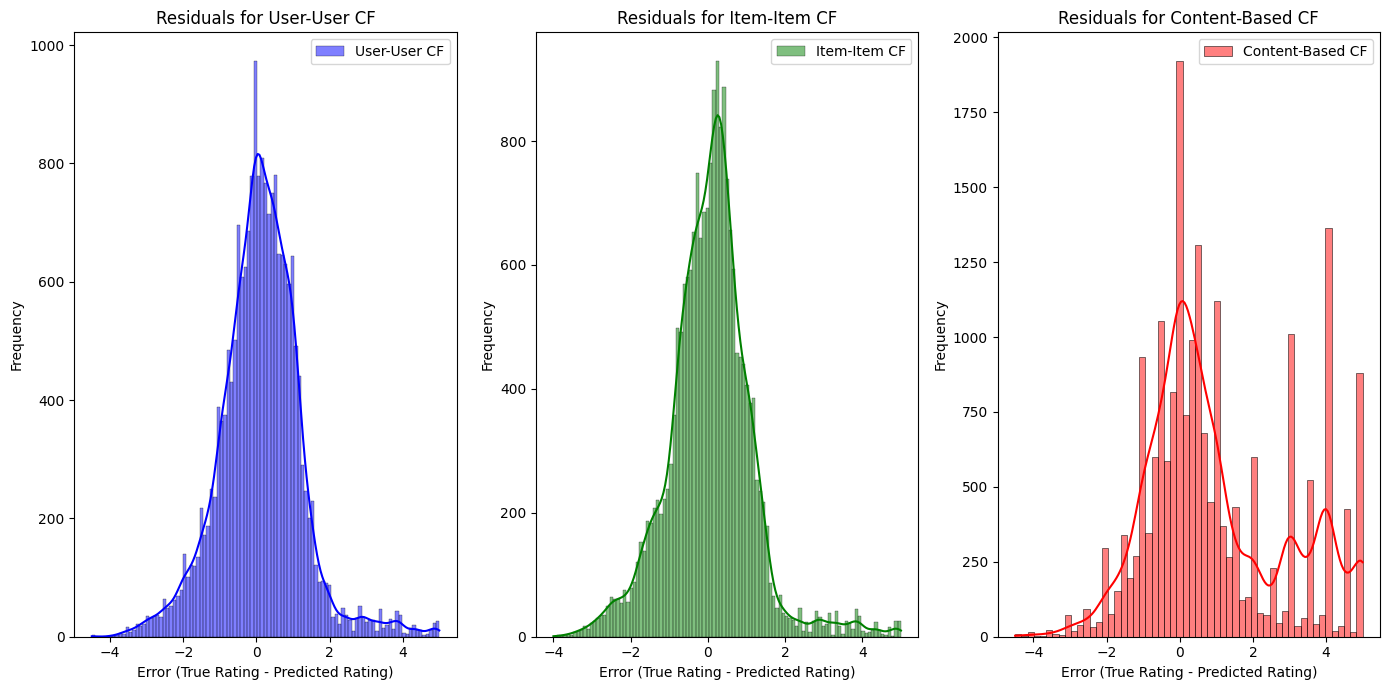

In [107]:
# Create Dataframes for true and predecited ratings
user_user_results = pd.DataFrame({
    'true_ratings': y_true_user_user,
    'predicted_ratings': y_pred_user_user
})

item_item_results = pd.DataFrame({
    'true_ratings': y_true_item_item,
    'predicted_ratings': y_pred_item_item
})

content_based_results = pd.DataFrame({
    'true_ratings': y_true_content_based,
    'predicted_ratings': y_pred_content_based
})

# Calculate residuals for each model
user_user_residuals = user_user_results['true_ratings'] - user_user_results['predicted_ratings']
item_item_residuals = item_item_results['true_ratings'] - item_item_results['predicted_ratings']
content_based_residuals = content_based_results['true_ratings'] - content_based_results['predicted_ratings']

# Plot the residuals for each model
plt.figure(figsize=(14, 7))

# User-User residuals
plt.subplot(1, 3, 1)
sns.histplot(user_user_residuals, kde=True, color='blue', label='User-User CF')
plt.title('Residuals for User-User CF')
plt.xlabel('Error (True Rating - Predicted Rating)')
plt.ylabel('Frequency')
plt.legend()

# Item-Item residuals
plt.subplot(1, 3, 2)
sns.histplot(item_item_residuals, kde=True, color='green', label='Item-Item CF')
plt.title('Residuals for Item-Item CF')
plt.xlabel('Error (True Rating - Predicted Rating)')
plt.ylabel('Frequency')
plt.legend()

# Content-Based residuals
plt.subplot(1, 3, 3)
sns.histplot(content_based_residuals, kde=True, color='red', label='Content-Based CF')
plt.title('Residuals for Content-Based CF')
plt.xlabel('Error (True Rating - Predicted Rating)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


##### Analysis:

- **User-User CF**: This model shows the most consistent and accurate predictions, with residuals tightly centered around zero. It slightly under-predicts ratings, but the errors are minimal.

- **Item-Item CF**: The residuals are more spread out, indicating larger prediction errors and less accuracy compared to User-User CF. This model may benefit from further refinement.

- **Content-Based CF**: This model tends to under-predict ratings more frequently, with a sharp peak around zero and some negative residuals. It may need improvement in capturing relevant features for better accuracy.


**Overall**, User-User CF performs the best, followed by Item-Item CF, with Content-Based CF requiring further adjustments.


# Conclusions

### Performance Summary
- **User-User Collaborative Filtering**:
  - Achieved an RMSE of **1.1437** and MAE of **0.8385**, indicating good performance but slightly behind Item-Item CF in accuracy.
  - **Strength**: Performs well when users share overlapping preferences. The residuals are tightly centered around zero, indicating minimal errors in predictions. It slightly under-predicts ratings, but the errors are minimal.
  - **Limitation**: Struggles with sparse user data, where overlapping preferences may not be sufficient for accurate predictions.

- **Item-Item Collaborative Filtering**:
  - Delivered the best performance with the lowest RMSE (**1.1044**)  and MAE (**0.8011**), making it the most accurate model.
  - **Strength**: Highly effective for users with limited rated items, leveraging item similarity for predictions. It handles sparse data better than User-User CF. The residuals are more spread out, suggesting larger prediction errors, but still shows the most consistent accuracy overall.
  - **Limitation**: May face challenges when items have insufficient rating data or lack common features to compare.

- **Content-Based Filtering**:
  - Performed the weakest, with the highest RMSE (**2.1264**) and MAE (**1.5309**), showing significant room for improvement.
  - **Strength**: Useful for recommending niche movies, particularly when user history is unavailable or for highly specific user preferences.
  - **Limitation**: Relies heavily on item metadata (e.g., genre), which may not always reflect user preferences accurately, leading to under-predictions for many ratings. The residuals show a sharp peak around zero with some negative values, indicating that it under-predicts ratings more frequently.

### Overall Performance:
- **Item-Item CF** consistently provided the best results, with the lowest RMSE and MAE, making it the most reliable model for predicting ratings in this scenario.
- **User-User CF** performed slightly worse but still achieved strong results, with minimal residuals and minor under-predictions.
- **Content-Based CF** performed the least well, with higher residuals indicating that the model may need improvement in capturing user preferences more effectively, particularly beyond simple metadata features.

### Conclusion:
- **Item-Item Collaborative Filtering** is the best-performing model in this project, followed by **User-User Collaborative Filtering**.
- **Content-Based Filtering** requires further development to better capture the complexities of user preferences, particularly when detailed user history is unavailable.
